# Airport Analysis

for each airport we will calculate:
- the cancellation proportion of the airport
- average delay rate of the airport

In [21]:
# import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

candidates_rt = pd.read_csv('../data/temproary_data/candidate_roundTrip_route.csv')
candidates_rt['round_trip_route_IATA'] = candidates_rt['round_trip_route_IATA'].apply(eval)
roundTrips = pd.read_csv('../data/temproary_data/round_trip_flights.csv')
roundTrips['round_trip_route_IATA'] = roundTrips['round_trip_route_IATA'].apply(eval)
roundTrips['inbound_FL_DATE'] = pd.to_datetime(roundTrips['inbound_FL_DATE'])
roundTrips['outbound_FL_DATE'] = pd.to_datetime(roundTrips['outbound_FL_DATE'])
airports_info = pd.read_csv('../data/cleaned_data/Airport_Codes.csv')
tickets_info = pd.read_csv('../data/cleaned_data/Tickets.csv')

tickets_info = tickets_info.assign(
        sorted_route=tickets_info.apply(
            lambda x: tuple(
                sorted([x["ORIGIN_AIRPORT_IATA_CODE"], x["DEST_AIRPORT_IATA_CODE"]])
            ),
            axis=1,
        )
    )

round_trip_profit = pd.read_csv('../data/temproary_data/roundTrip_profit.csv')
round_trip_profit['round_trip_route_IATA'] = round_trip_profit['round_trip_route_IATA'].apply(eval)
avg_ticket_price = pd.read_csv('../data/temproary_data/average_ticket_price.csv')
all_flights = pd.read_csv('../data/original_data/Flights.csv')

# gather relevent data

airports_can = {i for pair in candidates_rt['round_trip_route_IATA'].values for i in pair}

candidate_roundTrips = roundTrips[roundTrips['round_trip_route_IATA'].isin(candidates_rt['round_trip_route_IATA'])]
candidate_airports = airports_info[airports_info['AIRPORT_IATA_CODE'].apply(lambda x: x in airports_can)]
candidate_tickets = tickets_info[tickets_info['sorted_route'].isin(candidates_rt['round_trip_route_IATA'])]

/opt/anaconda3/envs/tongConsultinInc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (3,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# The average delay rate of each airport

In [55]:
airport_avg_delay = pd.DataFrame(columns=['airport', 'avg_delay_rate', 'var_delay_rate'])

for airport in candidate_airports['AIRPORT_IATA_CODE']:


    delay_data = pd.concat(
        [
            roundTrips[(roundTrips['inbound_ORIGIN_AIRPORT_IATA_CODE'] == airport)][['inbound_ORIGIN_AIRPORT_IATA_CODE', 'inbound_DEST_AIRPORT_IATA_CODE', 'inbound_DEP_DELAY', 'inbound_ARR_DELAY', 'inbound_AIR_TIME', 'inbound_DISTANCE', 'inbound_OCCUPANCY_RATE']].rename(
        columns={'inbound_ORIGIN_AIRPORT_IATA_CODE': 'ORIGIN_AIRPORT_IATA_CODE', 'inbound_DEST_AIRPORT_IATA_CODE': 'DEST_AIRPORT_IATA_CODE', 'inbound_DEP_DELAY': 'DEP_DELAY', 'inbound_ARR_DELAY': 'ARR_DELAY', 'inbound_AIR_TIME': 'AIR_TIME', 'inbound_DISTANCE': 'DISTANCE', 'inbound_OCCUPANCY_RATE': 'OCCUPANCY_RATE'}
    ), roundTrips[(roundTrips['outbound_ORIGIN_AIRPORT_IATA_CODE'] == airport)][['outbound_ORIGIN_AIRPORT_IATA_CODE', 'outbound_DEST_AIRPORT_IATA_CODE', 'outbound_DEP_DELAY', 'outbound_ARR_DELAY', 'outbound_AIR_TIME', 'outbound_DISTANCE', 'outbound_OCCUPANCY_RATE']].rename(
        columns={'outbound_ORIGIN_AIRPORT_IATA_CODE': 'ORIGIN_AIRPORT_IATA_CODE', 'outbound_DEST_AIRPORT_IATA_CODE': 'DEST_AIRPORT_IATA_CODE', 'outbound_DEP_DELAY': 'DEP_DELAY', 'outbound_ARR_DELAY': 'ARR_DELAY', 'outbound_AIR_TIME': 'AIR_TIME', 'outbound_DISTANCE': 'DISTANCE', 'outbound_OCCUPANCY_RATE': 'OCCUPANCY_RATE'}
    )
        ]
    )
    

    airport_avg_delay = airport_avg_delay.append({'airport': airport, 'avg_delay_rate': delay_data["DEP_DELAY"].mean(), 'var_delay_rate': delay_data["DEP_DELAY"].std()}, ignore_index=True)

airport_avg_delay['avg_delay_rate_rank'] = airport_avg_delay['avg_delay_rate'].rank(ascending = True)
airport_avg_delay['var_delay_rate_rank'] = airport_avg_delay['var_delay_rate'].rank(ascending = True)

airport_avg_delay = airport_avg_delay.rename(columns={'airport': 'AIRPORT_IATA_CODE'})

# the proportion of flights that got cancelled of each candidate round trip route

In [57]:
# filter out all the flights that are not in the candidate round trips
all_candidate_flights = all_flights[all_flights['ORIGIN'].isin(candidate_airports['AIRPORT_IATA_CODE'])]

can_airport_cancel_prop = all_candidate_flights.groupby('ORIGIN')['CANCELLED'].mean().reset_index().rename(columns={'CANCELLED': 'cancel_rate'})
can_airport_cancel_prop['cancel_rate_rank'] = can_airport_cancel_prop['cancel_rate'].rank(ascending = True)
can_airport_cancel_prop = can_airport_cancel_prop.rename(columns={'ORIGIN': 'AIRPORT_IATA_CODE'})

<BarContainer object of 14 artists>

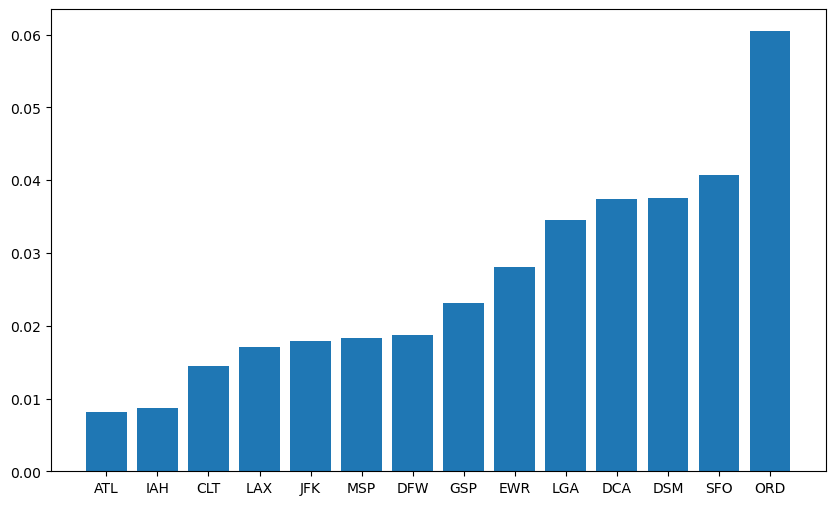

In [59]:
to_graph = can_airport_cancel_prop.sort_values(by='cancel_rate_rank', ascending = True)

fig = plt.figure(figsize=(10, 6))
plt.bar(to_graph['AIRPORT_IATA_CODE'], to_graph['cancel_rate'])

# Of all the cancelled flights, the proportion of the candidate airport takes

In [67]:
all_flights_cancelled = all_flights[all_flights['CANCELLED'] == 1]

all_cancel_prop_by_airport = all_flights_cancelled['ORIGIN'].value_counts(normalize=True).loc[candidate_airports['AIRPORT_IATA_CODE']].reset_index().rename(columns={'index': 'AIRPORT_IATA_CODE', 'ORIGIN': 'cancel_rate_all'})
all_cancel_prop_by_airport['cancel_rate_all_rank'] = all_cancel_prop_by_airport['cancel_rate_all'].rank(ascending = True)

# Final Analysis

In [73]:
airport_avg_delay

,AIRPORT_IATA_CODE,avg_delay_rate,var_delay_rate,avg_delay_rate_rank,var_delay_rate_rank
0,ATL,7.762100,37.824557,1.0,2.0
1,CLT,7.785211,33.803571,2.0,1.0
2,DCA,9.811942,44.775363,5.0,5.0
3,DFW,11.449630,42.435685,8.0,3.0
4,DSM,11.552156,57.068204,9.0,11.0
5,EWR,16.876395,56.081497,13.0,10.0
6,GSP,9.013617,57.559389,4.0,13.0
7,IAH,8.754002,43.988073,3.0,4.0
8,JFK,10.065133,48.289117,6.0,7.0
9,LAX,11.337498,44.997266,7.0,6.0


In [74]:
can_airport_cancel_prop

,AIRPORT_IATA_CODE,cancel_rate,cancel_rate_rank
0,ATL,0.008202,1.0
1,CLT,0.014437,3.0
2,DCA,0.037403,11.0
3,DFW,0.018782,7.0
4,DSM,0.037613,12.0
5,EWR,0.028124,9.0
6,GSP,0.023112,8.0
7,IAH,0.008745,2.0
8,JFK,0.017952,5.0
9,LAX,0.017115,4.0


In [72]:
all_cancel_prop_by_airport

,AIRPORT_IATA_CODE,cancel_rate_all,cancel_rate_all_rank
0,ATL,0.014899,6.0
1,CLT,0.017224,7.0
2,DCA,0.025729,11.0
3,DFW,0.025458,10.0
4,DSM,0.003236,2.0
5,EWR,0.020401,9.0
6,GSP,0.001879,1.0
7,IAH,0.007440,3.0
8,JFK,0.011024,4.0
9,LAX,0.019956,8.0


In [89]:
candidates_rt['airport_1'] = candidates_rt['round_trip_route_IATA'].apply(lambda x: x[0])
candidates_rt['airport_2'] = candidates_rt['round_trip_route_IATA'].apply(lambda x: x[1])

In [98]:
airport_rank_meta = candidates_rt.merge(
    airport_avg_delay[['AIRPORT_IATA_CODE', 'avg_delay_rate_rank', 'var_delay_rate_rank']],
    left_on='airport_1',
    right_on='AIRPORT_IATA_CODE',
).drop(columns=['AIRPORT_IATA_CODE']).rename(columns={'avg_delay_rate_rank': 'avg_delay_rate_rank_1', 'var_delay_rate_rank': 'var_delay_rate_rank_1'}).merge(
    airport_avg_delay[['AIRPORT_IATA_CODE', 'avg_delay_rate_rank', 'var_delay_rate_rank']],
    left_on='airport_2',
    right_on='AIRPORT_IATA_CODE',
).drop(columns=['AIRPORT_IATA_CODE']).rename(columns={'avg_delay_rate_rank': 'avg_delay_rate_rank_2', 'var_delay_rate_rank': 'var_delay_rate_rank_2'}).merge(
    can_airport_cancel_prop[['AIRPORT_IATA_CODE', 'cancel_rate_rank']],
    left_on='airport_1',
    right_on='AIRPORT_IATA_CODE',
).drop(columns=['AIRPORT_IATA_CODE']).rename(columns={'cancel_rate_rank': 'cancel_rate_rank_1'}).merge(
    can_airport_cancel_prop[['AIRPORT_IATA_CODE', 'cancel_rate_rank']],
    left_on='airport_2',
    right_on='AIRPORT_IATA_CODE',
).drop(columns=['AIRPORT_IATA_CODE']).rename(columns={'cancel_rate_rank': 'cancel_rate_rank_2'}).merge(
    all_cancel_prop_by_airport[['AIRPORT_IATA_CODE', 'cancel_rate_all_rank']],
    left_on='airport_1',
    right_on='AIRPORT_IATA_CODE',
).drop(columns=['AIRPORT_IATA_CODE']).rename(columns={'cancel_rate_all_rank': 'cancel_rate_all_rank_1'}).merge(
    all_cancel_prop_by_airport[['AIRPORT_IATA_CODE', 'cancel_rate_all_rank']],
    left_on='airport_2',
    right_on='AIRPORT_IATA_CODE',
).drop(columns=['AIRPORT_IATA_CODE']).rename(columns={'cancel_rate_all_rank': 'cancel_rate_all_rank_2'})

In [104]:
airport_rank_meta['airport_avg_ranking'] = airport_rank_meta.loc[:, 'avg_delay_rate_rank_1':'cancel_rate_all_rank_2'].mean(axis=1)

In [109]:
airport_rank_meta.sort_values(by='airport_avg_ranking', ascending = True).to_csv('../data/temproary_data/airport_rank_meta.csv', index=False)